# **시계열 데이터의 유사도 측정 방법 연구 (2)**

### 창원대 전자공학과 20145234 황주효 (Hwang Ju-hyo, Department of Electronic Engineering, Changwon University)
---

* 실제 설비 데이터에 적용해 다음을 시행해본다.
1. 알고리즘에 따른 유사도 그래프 및 연산시간 비교 (DTW, EDR, LCSS)
2. 각 알고리즘의 파라미터에 따른 분산 그래프 비교 (EDR, LCSS)

### **사용할 실제 데이터 불러오기 및 시각화**
---

In [143]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import ts_dist
import pyximport # pyximport.install()
import seaborn as sns
from ts_dist import dtw_dist as dtw_dist_py
from ts_dist import lcss_dist as lcss_dist_py
from ts_dist import edr_dist as edr_dist_py
from datetime import datetime

def load_data():
    data = pd.read_csv('data_new.csv')
    date = datetime.strptime(data['data_date'][0], '%Y-%m-%d %H:%M:%S.%f').strftime('%m/%d/%Y')
    date = pd.DataFrame(data['data_date'])
    data['date'] = date.applymap(str).applymap(lambda s: '{}-{}-{} {}:{}:{}'.format(
        s[0:4], s[5:7], s[8:10],s[11:13],s[14:16],s[17:19]))
    data.index = pd.to_datetime(data['date'])
    data = data.drop(columns = ['data_date', 'date'])
    data = data['2020-12-09 00:00:00':'2020-12-09 23:59:59']
    data.columns = ['oil_temperature']
    return data

data = load_data()

In [88]:
data.head()

,oil_temperature
date,
2020-12-09 00:00:00,1.33
2020-12-09 00:00:01,0.63
2020-12-09 00:00:02,0.63
2020-12-09 00:00:03,0.86
2020-12-09 00:00:04,0.86


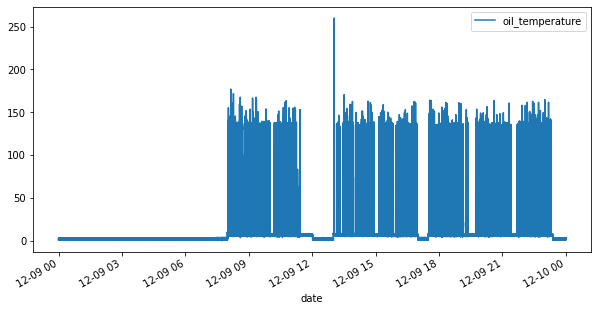

In [89]:
data.plot(figsize = (10, 5))
plt.show()

### **유사도를 측정할 기준 패턴**

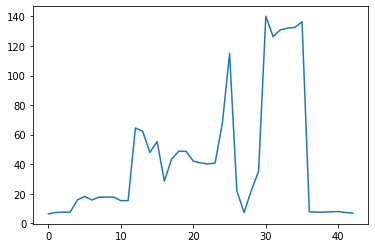

In [90]:
WINDOW_SIZE = 43
data_search = data['2020-12-09 15:32:28':'2020-12-09 15:33:10'].reset_index(drop=True)
plt.plot(data_search)
plt.show()

## 1. 알고리즘에 따른 유사도 그래프 및 연산시간 비교 (EDR, LCSS)
---

In [91]:
def execute_ts_als(data, data_search, al, delta = np.inf, epsilon = 0.5):
    from operator import itemgetter
    import time
    
    data = data
    data_search = data_search
    data_cal = 0
    find = []
    exe_time = 0
    delta = delta
    epsilon = epsilon
    
    if al == 'edr' : # EDR
        
        start = time.time()  # 시작 시간 저장
        for i in range(0, int((len(data)+1))):
            if i+WINDOW_SIZE <= len(data):
                data_cal = data.iloc[i:i+WINDOW_SIZE,]
                edr = edr_dist_py(data_search.T, data_cal.T, epsilon = epsilon) # 낮출수록 민감해진다
                diction = {'data_cal':data_cal, 'edr':edr, 'start_index': i}
                find.append(diction)
        exe_time = time.time() - start    
        
        find_sorted = sorted(find, key=itemgetter('edr'))

        edr_list = []
        for i in range(len(find_sorted)):
            edr_list.append(find_sorted[i]['edr'])

        index_list = []
        for i in range(len(find_sorted)):
            index_list.append(find_sorted[i]['start_index'])

        edr_list = pd.Series(edr_list)
        index_list = pd.Series(index_list)

        listed=  pd.concat((edr_list, index_list), axis = 1)
        listed.columns = ['edr', 'index_list']
        listed = listed.sort_values(by = 'index_list').reset_index(drop = True)
        listed = listed.drop(columns = 'index_list')
        
        return [exe_time, listed]
        
    if al == 'lcss' : # LCSS
        
        start = time.time()  # 시작 시간 저장
        for i in range(0, int((len(data)+1))):
            if i+WINDOW_SIZE <= len(data):
                data_cal = data.iloc[i:i+WINDOW_SIZE,]
                edr = lcss_dist_py(data_search.T, data_cal.T,delta = delta, epsilon = epsilon)
                diction = {'data_cal':data_cal, 'edr':edr, 'start_index': i}
                find.append(diction)
        exe_time = time.time() - start   
        
        find_sorted = sorted(find, key=itemgetter('edr'))

        edr_list = []
        for i in range(len(find_sorted)):
            edr_list.append(find_sorted[i]['edr'])

        index_list = []
        for i in range(len(find_sorted)):
            index_list.append(find_sorted[i]['start_index'])

        edr_list = pd.Series(edr_list)
        index_list = pd.Series(index_list)

        listed=  pd.concat((edr_list, index_list), axis = 1)
        listed.columns = ['lcss', 'index_list']
        listed = listed.sort_values(by = 'index_list').reset_index(drop = True)
        listed = listed.drop(columns = 'index_list')
        
        return [exe_time, listed]
    
    if al == 'dtw' : # DTW
        
        import fastdtw.fastdtw
        
        start = time.time()  # 시작 시간 저장
        for i in range(0, int((len(data)+1))):
            if i+WINDOW_SIZE <= len(data):
                data_cal = data.iloc[i:i+WINDOW_SIZE,]
                edr = fastdtw.fastdtw(data_search, data_cal)[0]
                diction = {'data_cal':data_cal, 'edr':edr, 'start_index': i}
                find.append(diction)
        exe_time = time.time() - start   
        
        find_sorted = sorted(find, key=itemgetter('edr'))

        edr_list = []
        for i in range(len(find_sorted)):
            edr_list.append(find_sorted[i]['edr'])

        index_list = []
        for i in range(len(find_sorted)):
            index_list.append(find_sorted[i]['start_index'])

        edr_list = pd.Series(edr_list)
        index_list = pd.Series(index_list)

        listed=  pd.concat((edr_list, index_list), axis = 1)
        listed.columns = ['dtw', 'index_list']
        listed = listed.sort_values(by = 'index_list').reset_index(drop = True)
        listed = listed.drop(columns = 'index_list')
        
        return [exe_time, listed]    

In [97]:
[dtw_time, dtw_list] = execute_ts_als(data, data_search, 'dtw')
[edr_time, edr_list] = execute_ts_als(data, data_search, 'edr', epsilon = 0.7)
[lcss_time, lcss_list] = execute_ts_als(data, data_search, 'lcss', delta = np.inf, epsilon = 0.7)

### **연산시간 비교**

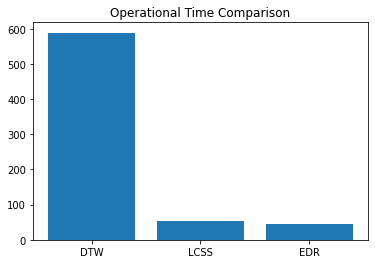

In [98]:
algs = ['DTW', 'LCSS', 'EDR']
values = [dtw_time, edr_time, lcss_time]

plt.bar(algs, values)
plt.title('Operational Time Comparison')
plt.show()

* DTW가 가장 느리고, EDR이 가장 연산속도가 빠르다.

### **유사도 그래프 비교**

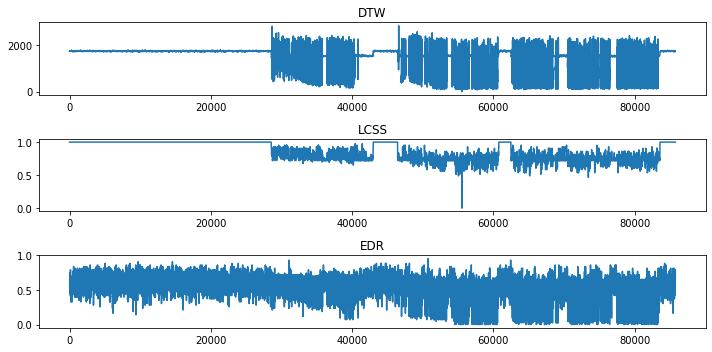

In [118]:
fig, ax = plt.subplots(3, 1, figsize = (10, 5))
ax[0].plot(range(len(dtw_list)),dtw_list)
ax[0].set_title('DTW')

ax[1].plot(range(len(lcss_list)),lcss_list)
ax[1].set_title('LCSS')

ax[2].plot(range(len(edr_list)),edr_list)
ax[2].set_title('EDR')

plt.tight_layout()
plt.show()

* DTW는 오차율에 대한 최대 한계치가 없으므로 제외
* 백분율로 치환할 수 있는 LCSS와 EDR에 대해 분포도 플로팅

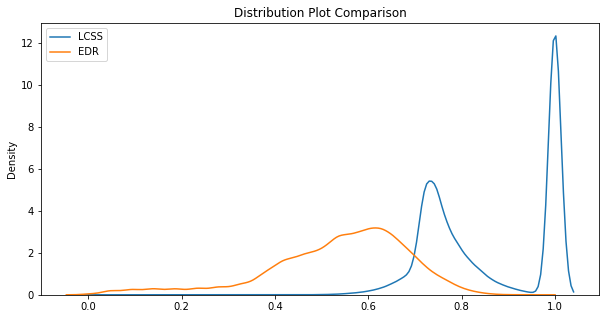

In [149]:
fig, ax = plt.subplots(1, 1, figsize = (10, 5))

ax = sns.distplot(lcss_list,hist = False, label = 'LCSS')
ax = sns.distplot(edr_list, hist = False, label = 'EDR')
ax.set_title('Distribution Plot Comparison')
plt.legend()
plt.show()

* EDR이 조금 더 골고루 분포해있다.
* 파라미터에 따라 분포가 다를 수 있다.

## **2. 각 알고리즘의 파라미터에 따른 분산 그래프 비교 (EDR, LCSS)** 
---

### **1) LCSS**

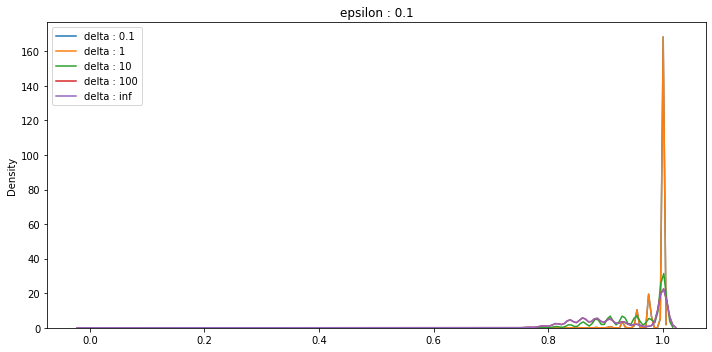

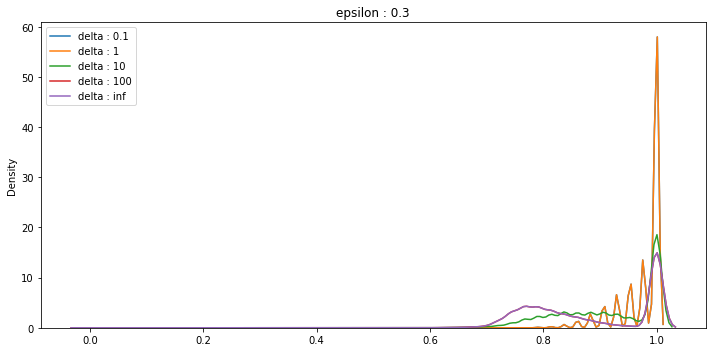

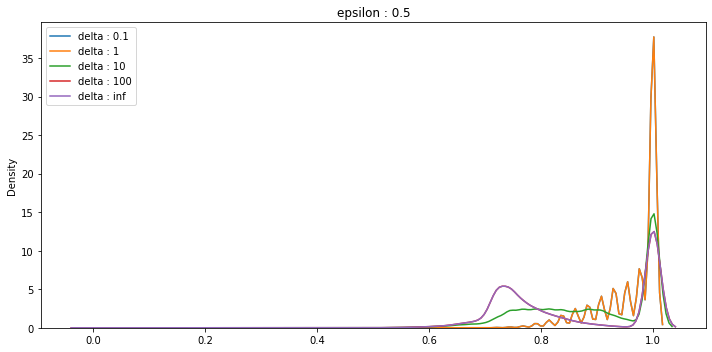

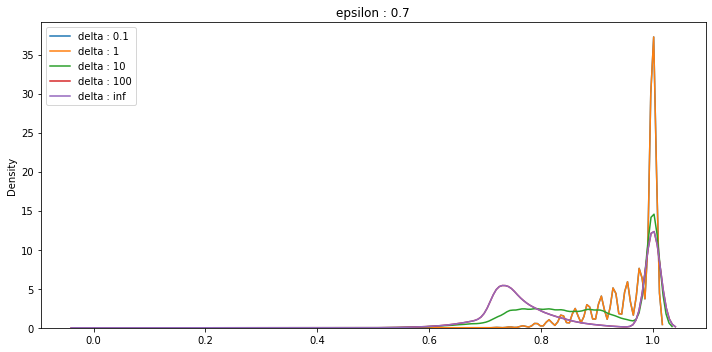

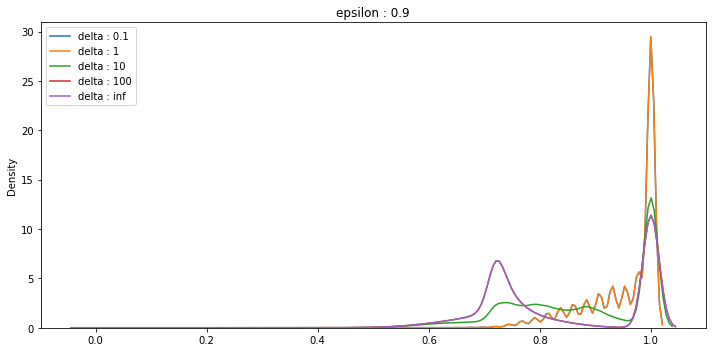

In [169]:
for e in [0.1, 0.3, 0.5, 0.7, 0.9]:
    fig, ax = plt.subplots(1, 1, figsize = (10, 5))
    epsilon = e
    for delta in [0.1, 1, 10, 100, np.inf]:
        [lcss_time, lcss_list] = execute_ts_als(data, data_search, 'lcss', delta = delta, epsilon = epsilon)
        ax = sns.distplot(lcss_list,hist = False, label = 'delta : {}'.format(delta))

    ax.set_title('epsilon : {}'.format(epsilon))
    plt.legend()
    plt.tight_layout()
    plt.show()

## **2) EDR**

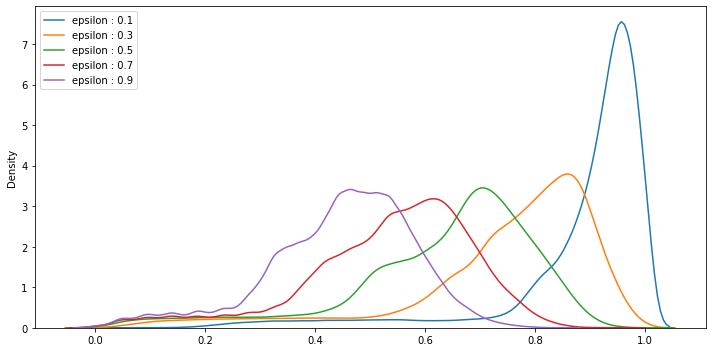

In [171]:
fig, ax = plt.subplots(1, 1, figsize = (10, 5))
for epsilon in [0.1, 0.3, 0.5, 0.7, 0.9]:
    [edr_time, edr_list] = execute_ts_als(data, data_search, 'edr', epsilon = epsilon)
    ax = sns.distplot(edr_list,hist = False, label = 'epsilon : {}'.format(epsilon))

plt.legend()
plt.tight_layout()
plt.show()